In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/twitter-entity-sentiment-analysis/twitter_validation.csv
/kaggle/input/twitter-entity-sentiment-analysis/twitter_training.csv


In [2]:

import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import re 
import seaborn as sns 
import nltk 
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer


import tensorflow as tf 
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, Dropout, LSTM, GlobalMaxPooling1D
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report



from wordcloud import wordcloud
from collections import Counter 



nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)

import warnings
warnings.filterwarnings("ignore")


2025-08-19 23:31:46.428626: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1755646306.790128      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1755646306.893704      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
training_df = pd.read_csv(r"/kaggle/input/twitter-entity-sentiment-analysis/twitter_training.csv")
validation_df = pd.read_csv(r"/kaggle/input/twitter-entity-sentiment-analysis/twitter_validation.csv")

In [4]:
training_df.columns = ['ID', 'Entity', 'Sentiment', 'Text']
validation_df.columns = ['ID', 'Entity', 'Sentiment', 'Text']

****Cleanning Data****

In [5]:
training_df.head()

,ID,Entity,Sentiment,Text
0,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
1,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
2,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
3,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...
4,2401,Borderlands,Positive,im getting into borderlands and i can murder y...


In [6]:
validation_df.head()

,ID,Entity,Sentiment,Text
0,352,Amazon,Neutral,BBC News - Amazon boss Jeff Bezos rejects clai...
1,8312,Microsoft,Negative,@Microsoft Why do I pay for WORD when it funct...
2,4371,CS-GO,Negative,"CSGO matchmaking is so full of closet hacking,..."
3,4433,Google,Neutral,Now the President is slapping Americans in the...
4,6273,FIFA,Negative,Hi @EAHelp I’ve had Madeleine McCann in my cel...


In [7]:
training_df.isna().sum()

ID             0
Entity         0
Sentiment      0
Text         686
dtype: int64

In [8]:
training_df.dropna(inplace=True)

In [9]:
training_df.shape

(73995, 4)

In [10]:
training_df.duplicated().sum()

2340

In [11]:
training_df.drop_duplicates(inplace=True)
training_df.shape

(71655, 4)

In [12]:
training_df.drop(columns = ['ID', 'Entity'],inplace=True)

In [13]:
training_df

,Sentiment,Text
0,Positive,I am coming to the borders and I will kill you...
1,Positive,im getting on borderlands and i will kill you ...
2,Positive,im coming on borderlands and i will murder you...
3,Positive,im getting on borderlands 2 and i will murder ...
4,Positive,im getting into borderlands and i can murder y...
...,...,...
74676,Positive,Just realized that the Windows partition of my...
74677,Positive,Just realized that my Mac window partition is ...
74678,Positive,Just realized the windows partition of my Mac ...
74679,Positive,Just realized between the windows partition of...


In [14]:
training_df.sample(10)

,Sentiment,Text
33579,Neutral,Friday already. The fortnight to review. 1 Wha...
42773,Positive,Kindly unban pubg otherwise many young entrepr...
35683,Irrelevant,"At the same time, despite the fact that there ..."
18389,Neutral,My son Miles!!! He's grown up so big . .
32305,Irrelevant,if you're going to call op a bad take and use ...
120,Positive,Finally played by Borderlands 3. The actual ga...
18345,Irrelevant,See @imjustbait.. because i ’ m winning
13999,Neutral,With so many stunning personalities like est.e...
2166,Negative,That's why I didn't buy Borderlands 3. Randy P...
18627,Negative,You ’ one re a terrorist.


**Text Processing**

In [15]:
def processed_text(text):
    # text normalization
    text = text.lower()
    # removing links
    text = re.sub(r"http\S+|www\S+|https\S+", ' ', text)
    # removing punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # remove numbers
    text = re.sub(r"\d+", ' ', text)
    # remove extra spaces
    text = re.sub(r"\s+", ' ', text).strip()
    # remove emojis
    text = re.sub(r'[^\x00-\x7F]+', ' ', text)
    replace_list = {
        "isn't" : "is not",
        "won't" : "would not",
        "im" : "i am",
        "can't" : "can not",
        "don't" : "do not",
        "should't" : "should not",
        "needn't": "need not",
        "hasn't": "has not",
        "haven't": "have not",
        "weren't": "were not",
        "mightn't": "might not",
        "didn't": "did not",
        "n't": " not",
        "'re": " are",
        "'s": " is",
        "'d": " would",
        "'ll": " will",
        "'t": " not",
        "'ve": " have",
        "'m": " am",
    }
    # apply  replacements
    for pattern, replace in replace_list.items():
        text = re.sub(pattern, replace, text)

    return text


In [16]:
print(training_df['Text'].head())
print(type(training_df['Text'].iloc[0]))


0    I am coming to the borders and I will kill you...
1    im getting on borderlands and i will kill you ...
2    im coming on borderlands and i will murder you...
3    im getting on borderlands 2 and i will murder ...
4    im getting into borderlands and i can murder y...
Name: Text, dtype: object
<class 'str'>


In [17]:
training_df['Text'] = training_df['Text'].astype(str)
validation_df['Text'] = validation_df['Text'].astype(str)

In [18]:
training_df['Text'] = training_df['Text'].apply(processed_text)
validation_df['Text'] = validation_df['Text'].apply(processed_text)

In [19]:
stemmer = PorterStemmer()
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    words = text.split()
    processed_words = [stemmer.stem(word) for word in words if word not in stop_words]
    return ' '.join(processed_words)

training_df['Text'] = training_df['Text'].apply(preprocess_text)
validation_df['Text'] = validation_df['Text'].apply(preprocess_text)

In [20]:
label_encoder = LabelEncoder()
training_df['Sentiment'] = label_encoder.fit_transform(training_df['Sentiment'])
training_df

,Sentiment,Text
0,3,come border kill
1,3,get borderland kill
2,3,come borderland murder
3,3,get borderland murder
4,3,get borderland murder
...,...,...
74676,3,realiz window partit mac like year behind nvid...
74677,3,realiz mac window partit year behind nvidia dr...
74678,3,realiz window partit mac year behind nvidia dr...
74679,3,realiz window partit mac like year behind nvid...


In [21]:
label_encoder = LabelEncoder()
validation_df['Sentiment'] = label_encoder.fit_transform(validation_df['Sentiment'])
validation_df

,ID,Entity,Sentiment,Text
0,352,Amazon,2,bbc news amazon boss jeff bezo reject clai am ...
1,8312,Microsoft,1,microsoft pay word function poorli samsungu ch...
2,4371,CS-GO,1,csgo matchmak full closet hack truli aw game
3,4433,Google,2,presid slap american face realli commit unlaw ...
4,6273,FIFA,1,hi eahelp madelein mccann cellar past year lit...
...,...,...,...,...
994,4891,GrandTheftAuto(GTA),0,toronto art cultur capit canada wonder want st...
995,4359,CS-GO,0,actual good move tot bring viewer one peopl go...
996,2652,Borderlands,3,today suck ti ame drink wine n play borderland...
997,8069,Microsoft,3,bought fraction microsoft today small win


In [22]:
tokenizer = Tokenizer(num_words = 10000)
tokenizer.fit_on_texts(training_df['Text'])
train_sequence = tokenizer.texts_to_sequences(training_df['Text'])
valid_sequence = tokenizer.texts_to_sequences(validation_df['Text'])

max_sequence_length = 100  

x = pad_sequences(train_sequence, maxlen = max_sequence_length)  
x_val = pad_sequences(valid_sequence, maxlen = max_sequence_length)  

In [23]:
import pickle

with open('tokenizer_she.pkl', 'wb') as file:
    pickle.dump(tokenizer, file)

print("Tokenizer has been saved.")

Tokenizer has been saved.


In [24]:
x_train, x_test, y_train, y_test = train_test_split(x, training_df['Sentiment'], test_size = 0.2, random_state = 45)

In [25]:
x_train = np.array(x_train)
x_test = np.array(x_test)
x_val = np.array(x_val)

train_labels = np.array(y_train)
test_labels = np.array(y_test)
val_labels = np.array(validation_df['Sentiment'].values)

**Bulding Model**

In [26]:
model = Sequential([
    Embedding(input_dim = 10000, output_dim = 100, input_length = max_sequence_length),
    LSTM(64, return_sequences = True),
    LSTM(32),
    #Dropout(0.3),
    Dense(4, activation = 'softmax')
])

model.compile(
    optimizer = Adam(learning_rate = 0.0001),
    loss = 'sparse_categorical_crossentropy',
    metrics = ['accuracy']
)

check_point = ModelCheckpoint('sentiment_analysis.keras', verbose = 0, save_best_only = True)

I0000 00:00:1755646342.853333      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1755646342.854129      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


In [27]:
history = model.fit(
    x_train, train_labels,
    validation_data = (x_val, val_labels),
    epochs = 25,
    batch_size = 64,
    verbose = 1,
    callbacks = [check_point]
)

Epoch 1/25


I0000 00:00:1755646348.334393      60 cuda_dnn.cc:529] Loaded cuDNN version 90300


896/896 ━━━━━━━━━━━━━━━━━━━━ 16s 11ms/step - accuracy: 0.3428 - loss: 1.3387 - val_accuracy: 0.5696 - val_loss: 1.0248
Epoch 2/25
896/896 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.5841 - loss: 1.0115 - val_accuracy: 0.7007 - val_loss: 0.7842
Epoch 3/25
896/896 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.6801 - loss: 0.8218 - val_accuracy: 0.7798 - val_loss: 0.6018
Epoch 4/25
896/896 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.7472 - loss: 0.6725 - val_accuracy: 0.8198 - val_loss: 0.5234
Epoch 5/25
896/896 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.7856 - loss: 0.5780 - val_accuracy: 0.8388 - val_loss: 0.4628
Epoch 6/25
896/896 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.8059 - loss: 0.5182 - val_accuracy: 0.8689 - val_loss: 0.4028
Epoch 7/25
896/896 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.8219 - loss: 0.4842 - val_accuracy: 0.8689 - val_loss: 0.3905
Epoch 8/25
896/896 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.8386 - loss: 0.4375 - val_accuracy: 0.

In [28]:
test_loss, test_accuracy = model.evaluate(x_test,test_labels)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

448/448 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8191 - loss: 0.6411
Test Accuracy: 82.05%


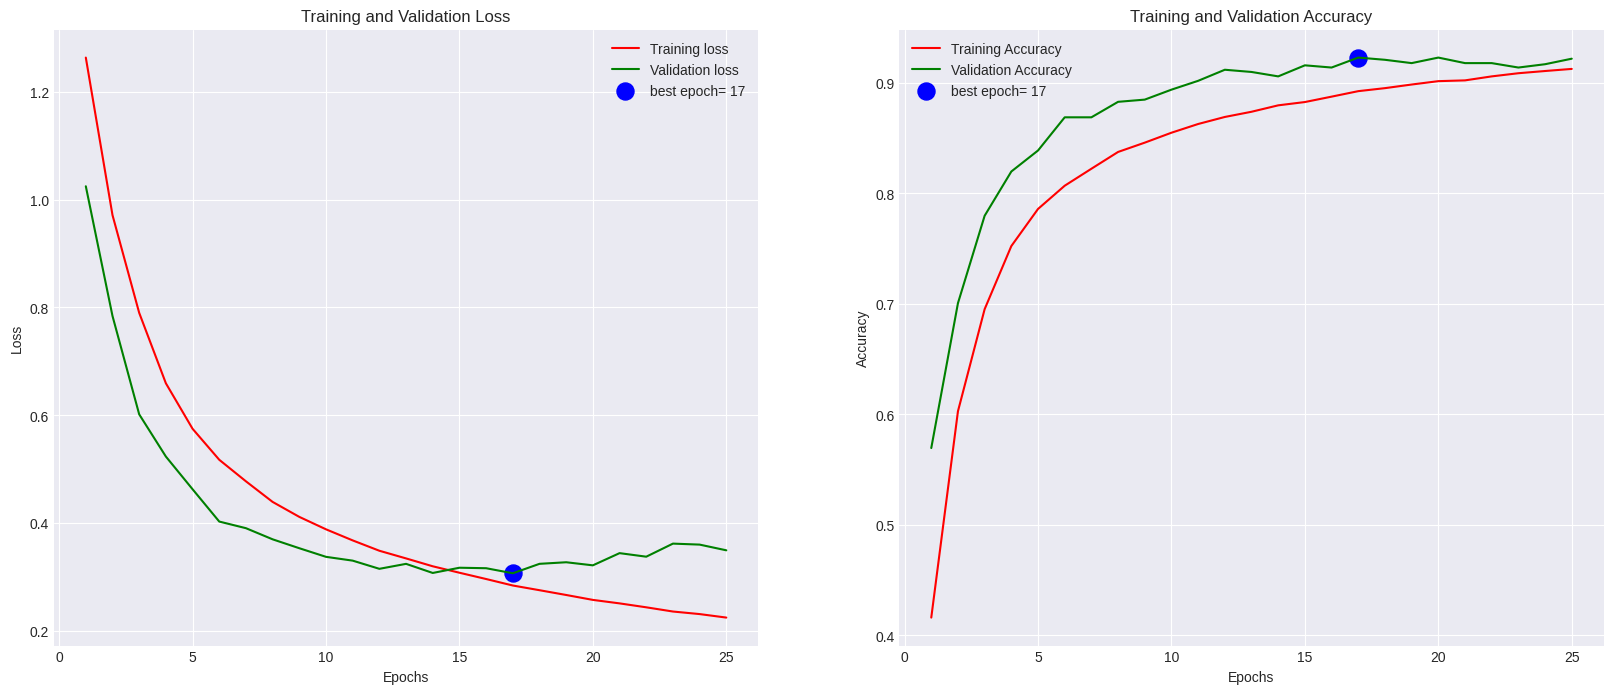

In [29]:
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('seaborn-v0_8-darkgrid')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

In [30]:
model.save('tesentmodel_v2.h5')

In [31]:
y_pred = model.predict(x_test)
y_pred = np.argmax(y_pred, axis = 1)

448/448 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step


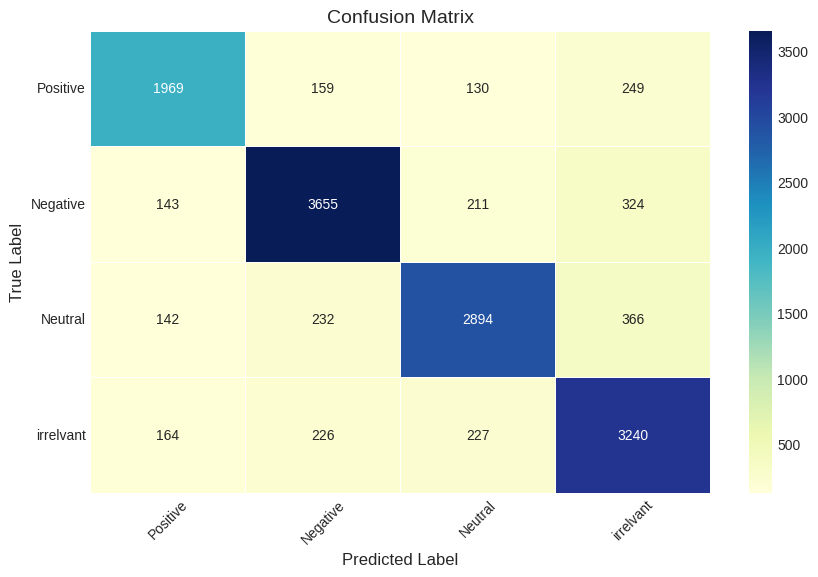

In [32]:
con_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (10,6))
sns.heatmap(con_matrix, annot=True, fmt='d', cmap="YlGnBu", xticklabels = ['Positive', 'Negative', 'Neutral','irrelvant'], yticklabels=['Positive', 'Negative', 'Neutral','irrelvant'], linewidths=0.5)
plt.title("Confusion Matrix", fontsize=14)
plt.xlabel("Predicted Label", fontsize=12)
plt.ylabel("True Label", fontsize=12)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()

In [33]:
report = classification_report(y_test, y_pred)
print('Classfication Report')
print(report)

Classfication Report
              precision    recall  f1-score   support

           0       0.81      0.79      0.80      2507
           1       0.86      0.84      0.85      4333
           2       0.84      0.80      0.82      3634
           3       0.78      0.84      0.81      3857

    accuracy                           0.82     14331
   macro avg       0.82      0.82      0.82     14331
weighted avg       0.82      0.82      0.82     14331



In [34]:
def preprocess_txt(texts, tokenizer):
    """
    Preprocess new incoming text data.

    Args:
        texts (list of str): List of raw text inputs.
        tokenizer (Tokenizer): Pre-trained tokenizer.
        max_len (int): Maximum sequence length.

    Returns:
        np.array: Padded sequences ready for prediction.
    """
    # Convert text to sequences

    text_seq = tokenizer.texts_to_sequences([texts])
    
    # Apply padding
    text_padded = pad_sequences(text_seq, maxlen = 100, padding="post")
    
    return text_padded

In [35]:
def predict_data(text, model, tokenizer, max_len=100):
    text_cleaned = processed_text(text)
    
    # Convert to sequence
    seq = tokenizer.texts_to_sequences([text_cleaned])
    
    # Pad
    seq_padded = pad_sequences(seq, maxlen=max_len, padding="post")
    
    # Predict
    y_pred = model.predict(seq_padded)
    pred_idx = np.argmax(y_pred, axis=1)[0]
    
    classes = ['Positive', 'Negative', 'Neutral', 'Irrelevant']
    return classes[pred_idx]

In [36]:
with open('/kaggle/working/tokenizer_she.pkl', "rb") as f:
    tokenizer = pickle.load(f)


test_model = tf.keras.models.load_model('/kaggle/working/tesentmodel_v2.h5')

In [37]:
txt = "I absolutely hate this product! It hardly works and makes me so angry."

print("Processed:", processed_text(txt))
print("Sequences:", tokenizer.texts_to_sequences(processed_text(txt)))

pred_class = predict_data(txt, test_model, tokenizer)

print(f'Predicted Class :{pred_class}')

Processed: i absolutely hate this product it hardly works and makes me so angry
Sequences: [[], [], [], [329], [], [], [439], [111], [], [218], [439], [], [], [407], [], [], [218], [], [], [407], [], [], [], [340], [217], [], [], [111], [328], [], [], [], [], [], [407], [], [217], [], [439], [], [], [284], [], [217], [16], [], [], [], [214], [], [], [], [], [16], [218], [], [], [], [218], [], [], [], [], [], [214], [244], [217], []]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 324ms/step
Predicted Class :Neutral


In [38]:
txt = "I absolutely love this product! It works perfectly and makes me so happy."
text_padded = preprocess_txt([txt], tokenizer)
print(text_padded[0][:20])  # first 20 tokens after padding
pred = test_model.predict(text_padded)
print(np.argmax(pred))

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
3
